# Импорт используемых библиотек и датасета

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
import math
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import xgboost
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import shap
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

In [2]:
PATHES = ["./with_closed_ations_as________select_app_2018_X5_STORES.csv", "./with_closed_ations_as________select_app_2019_X5_STORES.csv", "with_closed_ations_as________select_app_2020_X5_STORES.csv"]
# df = pd.read_csv(PATH)
df = pd.DataFrame()
for path in PATHES:
    df1 = pd.read_csv(path)
    df = pd.concat([df, df1])
    
df['action_date'] = pd.to_datetime(df['action_date'])
df = df[df['position_name'] == 'Продавец-кассир']

Columns (6,7) have mixed types.Specify dtype option on import or set low_memory=False.


# Обработка датасета

In [3]:
df = df[df['is_active_action'] == 1]
df["is_active_action"] = df.is_active_action.replace({True: 1, False: 0})
df["is_open_action"] = df.is_open_action.replace({True: 1, False: 0})

In [4]:
# Расчет дней
from functools import singledispatch
@singledispatch
def toDays(time_delta):
    return time_delta
@toDays.register
def _(time_delta: pd.Timedelta):
    return time_delta.total_seconds()/60/60/24
@toDays.register
def _(time_delta: pd.Series):
    return time_delta.dt.total_seconds()/60/60/24

In [5]:
# Сортируем по аппликантам и по времени
df.sort_values(by=['id_applicant','action_date'], ascending = [False,True], inplace = True)
df.reset_index(drop = True, inplace = True)

# расчет времения действий
indexes = pd.RangeIndex(len(df) - 1)
df['action_time'] = toDays(df.iloc[indexes + 1]['action_date'].reset_index(drop = True) - df['action_date']) # In days
df['action_time'].iloc[df[df['id_applicant'] !=  df.iloc[indexes+1].append({'id_applicant': 0}, ignore_index = True)['id_applicant'].reset_index(drop = True)].index] = None


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
df['is_fits'] = 0
df.loc[df['result_name'] == 'Принят', 'is_fits'] = 1

In [7]:
# Вывод законченных действий
applicants_fits =  df.groupby(['id_applicant'])['is_fits'].sum()
df_fits = df[df['id_applicant'].isin(applicants_fits[applicants_fits > 0].index)].reset_index()
df_fits = df_fits[df_fits['is_active_action'] == 1]

In [8]:
# Количество кандидатов
len(df_fits['id_applicant'].unique())

201148

In [9]:
# Один кандидат по партнеру
df_fits['Date_int'] = df_fits['action_date'].values.astype('int64')
partner_applicant =  df_fits.groupby(['id_partner','id_applicant'])['Date_int'].max().reset_index()
amount_applicant =  partner_applicant.groupby(['id_partner'])['Date_int'].max().reset_index()
partner_applicant = partner_applicant[partner_applicant['Date_int'].isin(amount_applicant['Date_int'])]
df_fits = pd.DataFrame(df_fits).drop(columns = 'Date_int')

df_fits = df_fits[df_fits['id_applicant'].isin(partner_applicant['id_applicant'])].reset_index(drop = True)

len(df_fits['id_applicant'].unique())

193767

In [10]:
# Обнуление после последнего принятия
fits_max =  df_fits[df_fits['result_name'] == 'Принят'].groupby(['id_applicant'])['action_date'].max().reset_index()
df_fits.loc[df_fits['action_date'].isin(fits_max['action_date']) & (df_fits['action_time'].notna()), 'after_fit'] = 1
while True:
    after_indexes = df_fits[(df_fits['action_time'].notna())& (df_fits['after_fit'] == 1)].index
    after_fit_mask = (df_fits.index.isin(after_indexes + 1) & (df_fits['action_time'].notna())) & df_fits['after_fit'].isna()
    if len(df_fits.loc[after_fit_mask]) == 0:
        break
    df_fits.loc[after_fit_mask, 'after_fit'] = 1

In [11]:
df_fits.loc[df_fits['after_fit'] == 1, 'action_time'] = 0

In [12]:
# Обнуление стадий с результатом: Недозвон,  Нет обратной связи, Ожидание, и т.п.
results_empty = ['Резерв', 'Не подходит', 'Не принят', 'Отказ кандидата', 'Отказ руководителя', 'Принят', 'Кадровый резерв']
for res in results_empty:
    df_fits.loc[(df_fits['result_name'] == res) & df_fits['action_time'].notna(), 'action_time'] = 0
    
df_fits.loc[(df_fits['stage_name'] == 'Создание кандидата') & df_fits['action_time'].notna(), 'action_time'] = 0

In [13]:
# ТТН по каждому аппликантам
df_tth =  df_fits.dropna(subset=['action_time']).groupby(['id_applicant', 'id_partner', 'department_id'])['action_time'].sum().reset_index()
df_tth.rename(columns={"action_time": "TTH"}, inplace = True)
df_fits = pd.merge(df_fits, df_tth[['id_applicant', 'TTH']], how = 'left', on="id_applicant")
df_tth

,id_applicant,id_partner,department_id,TTH
0,2196746,2393754,6715,27.685659
1,2196747,2314693,12252,6.133310
2,2196748,2346300,5760,28.251127
3,2196752,2393757,32391,17.202996
4,2196753,2393758,32156,10.153854
...,...,...,...,...
193762,4886560,1197774,35106,0.000151
193763,4886575,1542748,28162,0.000176
193764,4886579,3878216,10530,0.000182
193765,4886599,3884467,48259,0.000218


In [14]:
# ТТН по департаментам
df_tth_dep =  df_fits.dropna(subset=['action_time']).groupby(['id_applicant', 'department_id'])['action_time'].count().reset_index()
df_tth_dep = df_tth_dep.groupby(['department_id']).agg({'id_applicant':'count', 'action_time':'median'}).reset_index()

df_tth_dep.rename(columns={"id_applicant": "applicants","action_time": "TTH_median"}, inplace = True)
df_tth_dep

,department_id,applicants,TTH_median
0,5637,10,9.5
1,5638,4,9.0
2,5639,20,12.0
3,5640,6,12.5
4,5641,8,9.0
...,...,...,...
15545,49707,2,13.5
15546,49711,9,9.0
15547,49722,5,9.0
15548,49734,2,9.0


In [15]:
# Использование метода IsolationForest для предсказаний аномалий
df_tth = df_tth[df_tth['TTH'] >0.1]
forest_model=IsolationForest(random_state=0, contamination=.01).fit(df_tth[['TTH']])
df_tth['anomaly'] = forest_model.predict(df_tth[['TTH']])
df_tth

X does not have valid feature names, but IsolationForest was fitted with feature names

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id_applicant,id_partner,department_id,TTH,anomaly
0,2196746,2393754,6715,27.685659,1
1,2196747,2314693,12252,6.133310,1
2,2196748,2346300,5760,28.251127,1
3,2196752,2393757,32391,17.202996,1
4,2196753,2393758,32156,10.153854,1
...,...,...,...,...,...
193390,4874547,3857100,35046,2.984132,1
193391,4874561,3843493,24135,2.981270,1
193398,4874899,3847746,45624,2.944752,1
193399,4875075,3873082,9996,2.186676,1


In [16]:
# Функция построения подписей к графикам
def SetTTHLabels(table_name = 'TTH'):
    ax.set_title(table_name)
    ax.set_xlabel('TTH (Дни)')
    ax.set_ylabel('Количество')

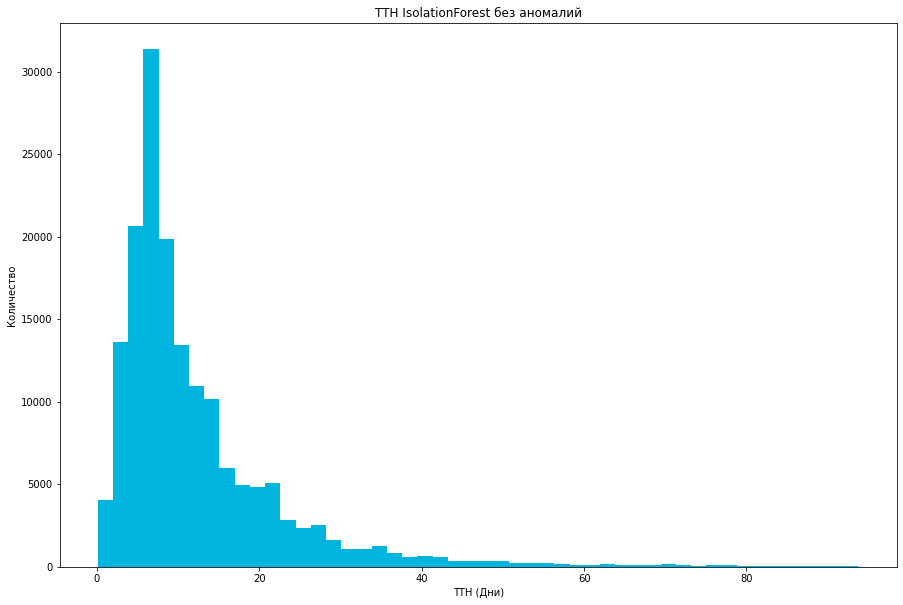

In [17]:
# TTH IsolationForest без аномалий
fig, ax = plt.subplots(1, 1,figsize=(15,10))
bins = 50
ax.hist(df_tth['TTH'][(df_tth['anomaly']==1)&(df_tth['TTH']>0.1)],bins=bins, color = "#00b5dd")
SetTTHLabels('TTH IsolationForest без аномалий')
plt.show()

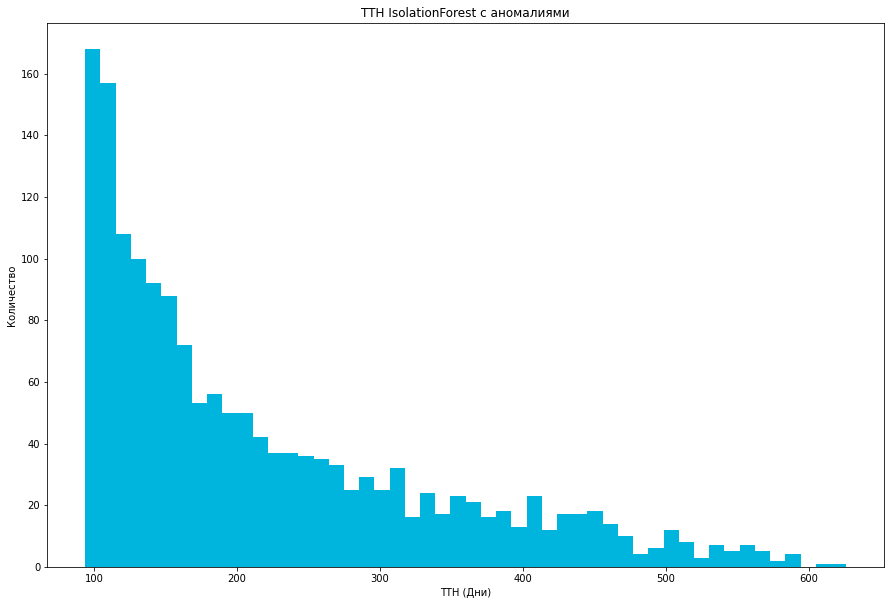

In [18]:
# TTH IsolationForest с аномалиями
fig, ax = plt.subplots(1, 1,figsize=(15,10))
bins = 50
ax.hist(df_tth['TTH'][(df_tth['anomaly']==-1)&(df_tth['TTH']<1000)],bins=bins, color = "#00b5dd")
SetTTHLabels('TTH IsolationForest с аномалиями')
plt.show()

In [19]:
# Генерация датасета без аномалий
treshold_down = 0.1
treshold_up = df_tth['TTH'].quantile(0.99)
print("Верхняя граница = "+ str(treshold_up))
df_norm = df_fits.loc[df_fits['id_applicant'].isin(df_tth.loc[df_tth['anomaly']==1, 'id_applicant'])]
df_norm = df_norm.loc[df_norm['id_applicant'].isin(df_tth.loc[df_tth['TTH'] >treshold_down, 'id_applicant'])]
df_tth = pd.DataFrame(df_tth).drop(columns = 'anomaly')
print(len(df_norm))


df_tth_norm = df_tth.loc[df_tth['id_applicant'].isin(df_norm['id_applicant'])]

Верхняя граница = 93.02681978548368
2043408


In [20]:
print("Количество не аномальных принятых кандидатов = "+ str(len(df_norm.id_applicant.unique())))

Количество не аномальных принятых кандидатов = 164271


In [21]:
# Функции подсчёта дней
def dfAllDays(df):
    date_min = df['action_date'].min().tzinfo.localize(pd.to_datetime(20180101, format='%Y%m%d'))
    day_max = int(toDays(df['action_date'].max() - date_min)) + 1 # In days
    range_days = range(0, day_max)
    return pd.DataFrame(range_days, range_days, columns =['days']) 
    
    
    
def stageInDays(stage_action_name, df, show_scatter = True, up_date_treshold = 730, applicants = False):
    stage_date = df[df['stage_name'] == stage_action_name].groupby(['id_applicant']). agg({'action_date': 'max','action_time':'sum'}).reset_index()
    stage_date = stage_date.rename(columns={"action_date": 'max_date'})
    stage_date = pd.merge(stage_date,df[df['stage_name'] == stage_action_name].groupby(['id_applicant'])['action_date'].min().reset_index(), how = 'left', on="id_applicant")
    stage_date = stage_date.rename(columns={"action_date": 'min_date'})

    date = stage_date['min_date'].min().tzinfo.localize(pd.to_datetime(20180101, format='%Y%m%d'))
    
    stage_date['stage_time_min'] = (toDays(stage_date['min_date'] - date)).astype(int) # In days
    stage_date['stage_time_max'] = (toDays(stage_date['max_date'] - date)).astype(int) # In days


    applicant_days = dfAllDays(df)
    applicant_days['applicants'] = 0
    for cur_date in applicant_days['days']:
        applicant_days.loc[cur_date,'applicants'] = len(stage_date[(stage_date['stage_time_max']>= cur_date)&(stage_date['stage_time_min']<= cur_date)])
    applicant_days = applicant_days[applicant_days['days'] < up_date_treshold]
    
    stage_date = pd.merge(stage_date, applicant_days.rename(columns={"days": 'stage_time_min'}), how = 'left', on="stage_time_min")
    if show_scatter:
        plt.subplots(figsize=(15,10))
        plt.scatter(applicant_days['days'], applicant_days['applicants'], linewidth=1, label="original",s=5)
        plt.title("Стадия "+ stage_action_name)
        plt.xlabel('Дни с начала 2018 года')
        plt.ylabel('Количество аппликантов на стадии')
        plt.grid(True)
        plt.show()
    if applicants:
        return applicant_days, stage_date
    else:
        return stage_date

# Регрессия и XGboost

In [22]:
def addTimeToDF(df, column_name, result_name, new_res_name, temp):
    temp = df[df[column_name]==result_name]
    temp = temp.dropna(subset=['action_time']).groupby(['id_applicant'])['action_time'].sum().reset_index()
    temp = temp.rename(columns={"action_time": new_res_name})
    df = pd.merge(df, temp, how = 'left', on="id_applicant")
    df.fillna(value = {new_res_name:0}, inplace = True)
    return df
def dfMeanTime(df, column_name, result, result_new_name):
    df_mean = df[df[column_name]==result].groupby(['id_applicant'])['action_time'].mean().reset_index()
    df_mean = df_mean.rename(columns={"action_time": result_new_name})
    return df_mean
def dfRepitable(df, column_name, result_name, new_result_name):
    temp_df = df_norm[df_norm[column_name]==result_name].groupby(['id_applicant', 'activity_name', 'stage_name'])['action_date'].count().reset_index()
    temp_df = temp_df.rename(columns={"action_date": "amount"})
    temp_df = temp_df[temp_df['amount']>1]
    df = pd.merge(df, temp_df.groupby(['id_applicant'])['amount'].sum(), how = 'left', on="id_applicant")
    df = df.rename(columns={"amount": "amount_over_2calls"})
    df = pd.merge(df, temp_df.groupby(['id_applicant'])['amount'].count(), how = 'left', on="id_applicant")
    df = df.rename(columns={"amount": "count_over_2calls"})
    df['mean_over_2calls'] = df['amount_over_2calls'] / df['count_over_2calls'] - 1
    df[df['mean_over_2calls'] < 0] = 0
    df = df.drop(['amount_over_2calls', 'count_over_2calls'] , axis=1)
    df = df.rename(columns={"mean_over_2calls": new_result_name})
    return df

In [23]:
fits_min =  df_norm[df_norm['result_name'] == 'Принят'].groupby(['id_applicant'])['action_date'].min().reset_index()

In [24]:
def dfRepitableAll(df, column_name, result_name, new_result_name):
    temp_df = df_norm[df_norm[column_name]==result_name].groupby(['id_applicant', 'activity_name', 'stage_name'])['action_date'].count().reset_index()
    temp_df = temp_df.rename(columns={"action_date": "amount"})

    df = pd.merge(df, temp_df.groupby(['id_applicant'])['amount'].sum(), how = 'left', on="id_applicant")
    df = df.rename(columns={"amount": "amount_over_2calls"})
    df = pd.merge(df, temp_df.groupby(['id_applicant'])['amount'].count(), how = 'left', on="id_applicant")
    df = df.rename(columns={"amount": "count_over_2calls"})
    df['mean_over_2calls'] = df['amount_over_2calls'] / df['count_over_2calls'] - 1
    df[df['mean_over_2calls'] < 0] = 0
    df = df.drop(['amount_over_2calls', 'count_over_2calls'] , axis=1)
    df = df.rename(columns={"mean_over_2calls": new_result_name})
    return df

In [25]:
df_reg_all = df_tth_norm.reset_index(drop=True)
df_reg_all = dfRepitableAll(df_reg_all,'stage_name','Оформление', 'Оформление недозвоны' )
df_reg_all['Оформление недозвоны'].to_excel('nedozv.xlsx')

In [26]:
def cutData(df_reg, yColumn, xColumns_del = []):
    
    xColumn = df_reg.columns
    yColumn = yColumn
    xColumns_del.append(yColumn)
    mask = np.isin(xColumn, xColumns_del, invert = True)
    xColumn = xColumn[mask]
    
    return df_reg[xColumn], xColumn

In [27]:
def lm(df_reg, yColumn, xColumns_del = [], scaler = preprocessing.StandardScaler()):
    
    xColumn = df_reg.columns
    yColumn = yColumn
    xColumns_del.append(yColumn)
    mask = np.isin(xColumn, xColumns_del, invert = True)
    xColumn = xColumn[mask]
            
    lr = LinearRegression()

    X_c = sm.add_constant(df_reg[xColumn])

    model = sm.OLS(df_reg[yColumn],X_c)
    fitted_model = model.fit()
    
    return fitted_model, xColumn, fitted_model.predict(X_c)

def vizScatTTHPred(df, predicted, xColumns, yColumn):
    column_names = ['Кол-во недозвонов(оформление)', 'СБ', 'Интервью' ]
    xy = math.ceil(math.sqrt(len(xColumns)))
    if xy <2:
        xy = 2
    fig, axs = plt.subplots(xy, xy, figsize=(13,13))
    i = 0
    for column in xColumns:
        x, y =divmod(i, xy)    
        axs[x,y].set_ylabel("TTH, дни")
        axs[x,y].set_xlabel(column_names[i])
        axs[x,y].scatter(df[column], df[yColumn],s=3, label="Оригинальные", color = '#a6ce28')
        axs[x,y].scatter(df[column], predicted,s=3, label="Предсказанные", color = '#8c50ff')
        i += 1
        axs[x,y].grid(True)
        axs[x,y].grid(linewidth = 0.5, ls ='--', color = grid_color)
        axs[x,y].legend(loc='best',fancybox=True, shadow=True,
              fontsize = 10)
    plt.show()
    
def vizResTTHPred(df, predicted, xColumns, yColumn):
    column_names = ['Кол-во недозвонов(оформление)', 'СБ', 'Интервью' ]
    xy = math.ceil(math.sqrt(len(xColumns)))
    if xy <2:
        xy = 2
    fig, axs = plt.subplots(xy, xy, figsize=(13,13))
    i = 0
    df.loc[:, 'res'] = df[yColumn] - predicted
    for column in xColumns:
        x, y =divmod(i, xy)    
        axs[x,y].set_ylabel("TTH, дни")
        axs[x,y].set_xlabel(column_names[i])
        axs[x,y].scatter(df[column],df['res'],s=3, color = '#a6ce28')
        i += 1
        axs[x,y].grid(True)
        axs[x,y].grid(linewidth = 0.5, ls ='--', color = grid_color)
    plt.show()
    df.drop(['res'] , axis=1)

In [28]:
def cutData(df_reg, yColumn, xColumns_del = []):
    
    xColumn = df_reg.columns
    yColumn = yColumn
    xColumns_del.append(yColumn)
    mask = np.isin(xColumn, xColumns_del, invert = True)
    xColumn = xColumn[mask]
    
    return df_reg[xColumn], xColumn

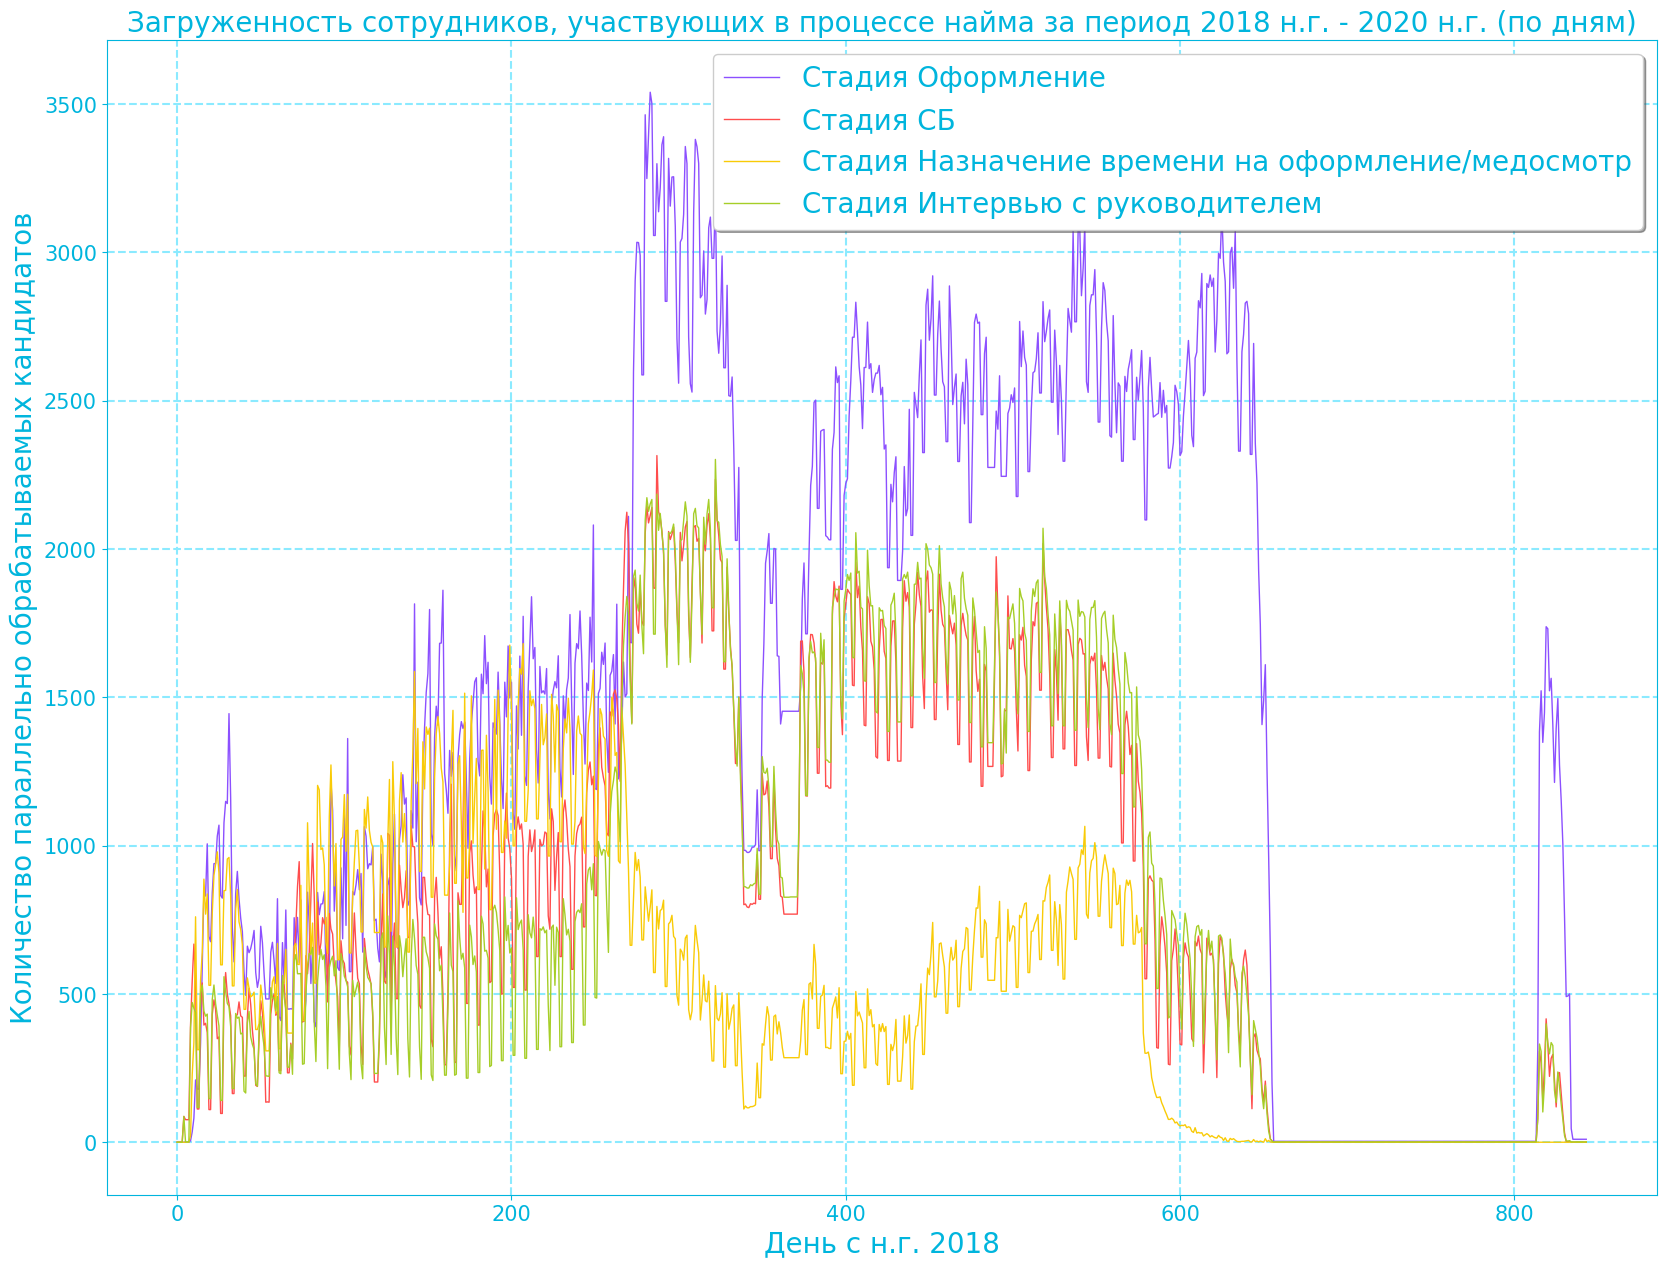

In [30]:
# График Загруженность сотрудников, участвующих в процессе найма за период 2018 н.г. - 2020 н.г. (по дням)
long_stages = ['Оформление', 'СБ', 'Назначение времени на оформление/медосмотр', 'Интервью с руководителем']
colors = ['#00b5dd','#8c50ff', '#ff4d4d', '#f9cb07', '#a6ce28']
grid_color = '#8beaff'

df_long_stages = dfAllDays(df_norm)
df_applicant_stages = pd.DataFrame(df_norm['id_applicant'].unique(), columns = ['id_applicant'])

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 15, 'text.color': colors[0],
                     'axes.labelcolor': colors[0], 'xtick.color': colors[0], 'ytick.color': colors[0],
                     'axes.edgecolor': colors[0], 'ytick.color': colors[0]})

plt.subplots(figsize=(20,15))
i = 1
for stage in long_stages:
    df_long_stage, df_applicant_stage = stageInDays(stage, df_norm, False, 9999, True)
    df_long_stages = pd.merge(df_long_stages, df_long_stage, how = 'left', on="days") 
    new_col_name = stage + ' аппликатнов'
    df_long_stages =  df_long_stages.rename(columns={"applicants": new_col_name})
    plt.plot(df_long_stages['days'], df_long_stages[new_col_name], label="Стадия " + stage, linewidth=1.0, color = colors[i])
    i += 1
    df_applicant_stages = pd.merge(df_applicant_stages, df_applicant_stage[['id_applicant', 'action_time', 'applicants']], how = 'left', on="id_applicant")
    df_applicant_stages =  df_applicant_stages.rename(columns={"applicants": new_col_name, 'action_time':stage+' время'}) 
    
df_applicant_stages = pd.merge(df_applicant_stages, df_tth[['id_applicant', 'TTH']], how = 'left', on="id_applicant") 
plt.title("Загруженность сотрудников, участвующих в процессе найма за период 2018 н.г. - 2020 н.г. (по дням)",
              fontsize = 20, color = colors[0])
plt.xlabel('День с н.г. 2018',
              fontsize = 20, color = colors[0])
plt.ylabel('Количество параллельно обрабатываемых кандидатов',
              fontsize = 20, color = colors[0])
plt.legend(loc='best',fancybox=True, shadow=True,
              fontsize = 20)
plt.grid(True)
plt.grid(linewidth = 1.5, ls ='--', color = grid_color)
 
plt.show()


In [31]:

mask = np.isin(df_long_stages.columns, ['days'], invert = True)
df_long_stages_col = df_long_stages.columns[mask]

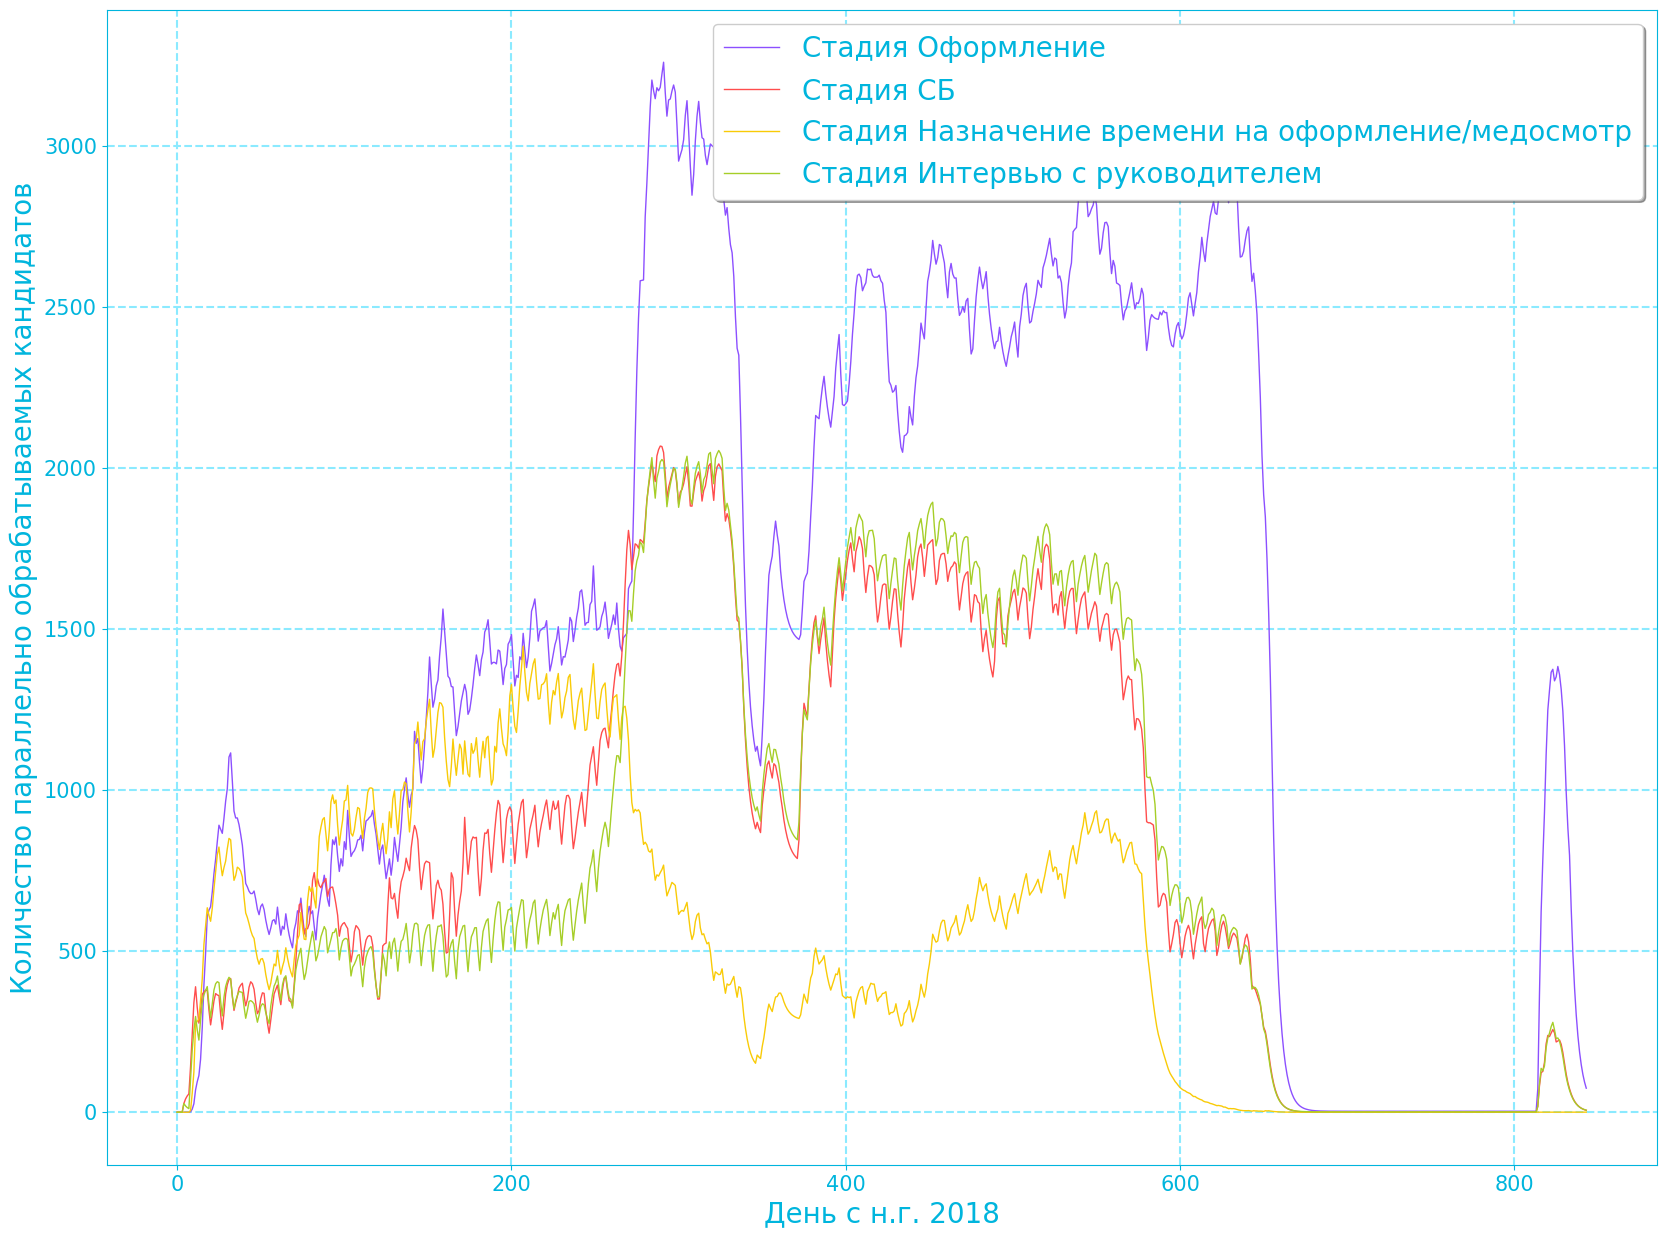

In [32]:
# График по среднему Загруженность сотрудников, участвующих в процессе найма за период 2018 н.г. - 2020 н.г. (по дням)

df_long_stages[df_long_stages_col] = df_long_stages[df_long_stages_col].ewm(com=3.5).mean()

i = 1
plt.subplots(figsize=(20,15))
for stage in long_stages:
    new_col_name = stage+ ' аппликатнов'
    df_long_stages =  df_long_stages.rename(columns={"applicants": new_col_name})
    plt.plot(df_long_stages['days'], df_long_stages[new_col_name], label="Стадия " + stage, linewidth=1.0, color = colors[i])

    i += 1

plt.xlabel('День с н.г. 2018',
              fontsize = 20)
plt.ylabel('Количество параллельно обрабатываемых кандидатов',
              fontsize = 20)
plt.legend(loc='best',fancybox=True, shadow=True,
              fontsize = 20)
plt.grid(True)
plt.grid(linewidth = 1.5, ls ='--', color = grid_color)
plt.show()


In [33]:
# Дни от начала 2018 года 
date_min = df_norm['action_date'].min().tzinfo.localize(pd.to_datetime(20180101, format='%Y%m%d'))
df_norm['days'] = (toDays(df_norm['action_date'] - date_min)).astype(int)  
df_norm = pd.merge(df_norm, df_long_stages, how = 'left', on="days")
df_applicant_stages = pd.merge(df_applicant_stages, df_norm[['id_applicant', 'days']], how = 'left', on="id_applicant")

In [34]:
# Был ли чел в резерве
temp_df = df[df['stage_name']=='Резерв'].id_partner.unique()
df_reg = df_tth_norm.reset_index(drop=True)

# Сезонность (В какой месяц) - 11 бинарных переменных
df_reg = pd.merge(df_reg, fits_min[['id_applicant','action_date']], how = 'left', on="id_applicant")
df_reg['month_start'] = df_reg['action_date'].dt.month
df_reg = df_reg.drop(['action_date'] , axis=1)
temp_df = pd.get_dummies(df_reg["month_start"]).rename(columns=lambda x: 'month '+str(int(x)))
df_reg =  pd.concat((temp_df, df_reg), axis=1)
df_reg = df_reg.drop(['month_start'] , axis=1)

# Сколько раз повторяются этапы на стадии (activity + stage name)
df_reg = dfRepitable(df_reg,'stage_name','Оформление', 'Оформление недозвоны' )

# Количество аппликантов в среднем за неделю
df_reg = pd.merge(df_reg, df_norm.groupby(['id_applicant'])[df_long_stages_col].mean().reset_index(), how = 'left', on="id_applicant")
df_reg = pd.merge(df_reg, dfMeanTime(df_norm, 'stage_name','СБ', "СБ (время)" ), how = 'left', on="id_applicant")
df_reg = pd.merge(df_reg, dfMeanTime(df_norm, 'stage_name','Интервью с руководителем', "Интервью с руководителем (время)" ), how = 'left', on="id_applicant")
df_reg = pd.merge(df_reg, dfMeanTime(df_norm, 'stage_name','Оформление', "Оформление (время)" ), how = 'left', on="id_applicant")

df_reg['СБ (время/среднее)'] = df_reg['СБ (время)'] / df_reg['СБ (время)'].mean()
df_reg['Интервью с руководителем (время/среднее)'] = df_reg['Интервью с руководителем (время)'] / df_reg['Интервью с руководителем (время)'].mean()

df_reg = df_reg.drop(['Интервью с руководителем (время)', 'СБ (время)', 'Оформление (время)'] , axis=1)
df_reg = df_reg.drop(['Интервью с руководителем аппликатнов', 'СБ аппликатнов', 'Назначение времени на оформление/медосмотр аппликатнов', 'Оформление аппликатнов'] , axis=1)
df_reg = df_reg.rename(columns={"Интервью с руководителем (время/среднее)": "Интервью (время/среднее)"})


# Время по стадиям
df_reg.replace([np.inf, -np.inf], np.nan, inplace=True)
df_reg = df_reg.fillna(0)
df_reg

,month 1,month 2,month 3,month 4,month 5,month 6,month 7,month 8,month 9,month 10,month 11,month 12,id_applicant,id_partner,department_id,TTH,Оформление недозвоны,СБ (время/среднее),Интервью (время/среднее)
0,0,1,0,0,0,0,0,0,0,0,0,0,2196746,2393754,6715,27.685659,3.0,1.843986,0.000023
1,1,0,0,0,0,0,0,0,0,0,0,0,2196747,2314693,12252,6.133310,0.0,2.287242,0.000026
2,0,1,0,0,0,0,0,0,0,0,0,0,2196748,2346300,5760,28.251127,0.0,2.297314,0.000026
3,1,0,0,0,0,0,0,0,0,0,0,0,2196752,2393757,32391,17.202996,4.0,2.331441,0.000022
4,1,0,0,0,0,0,0,0,0,0,0,0,2196753,2393758,32156,10.153854,1.0,1.837830,0.000025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164266,0,0,0,1,0,0,0,0,0,0,0,0,4874547,3857100,35046,2.984132,0.0,0.000011,0.000053
164267,0,0,0,1,0,0,0,0,0,0,0,0,4874561,3843493,24135,2.981270,0.0,0.000010,0.000043
164268,0,0,0,1,0,0,0,0,0,0,0,0,4874899,3847746,45624,2.944752,0.0,0.869699,0.059207
164269,0,0,0,1,0,0,0,0,0,0,0,0,4875075,3873082,9996,2.186676,1.0,0.000050,0.000046


In [35]:
yColumn = "TTH"
df_new, xColumn = cutData(df_reg,yColumn,['id_partner', 'department_id', 'id_applicant', 'TTH', 'year 2', 'month 12', 'yandex_source'])

model_xgb = xgboost.XGBRegressor().fit(df_new, df_reg['TTH'])
model_xgb.score(df_new, df_reg['TTH']) 

0.4088395103900707

In [36]:
y_pred = model_xgb.predict(df_new)
r_squared = r2_score(df_reg['TTH'], y_pred)
adjusted_r_squared = 1 - (1-r_squared)*(len(df_reg['TTH'])-1)/(len(df_reg['TTH'])-df_new.shape[1]-1)
print('R2 = '+str(r_squared))
print('R2 adj = '+str(adjusted_r_squared))

R2 = 0.4088395103900707
R2 adj = 0.40878912412196156


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


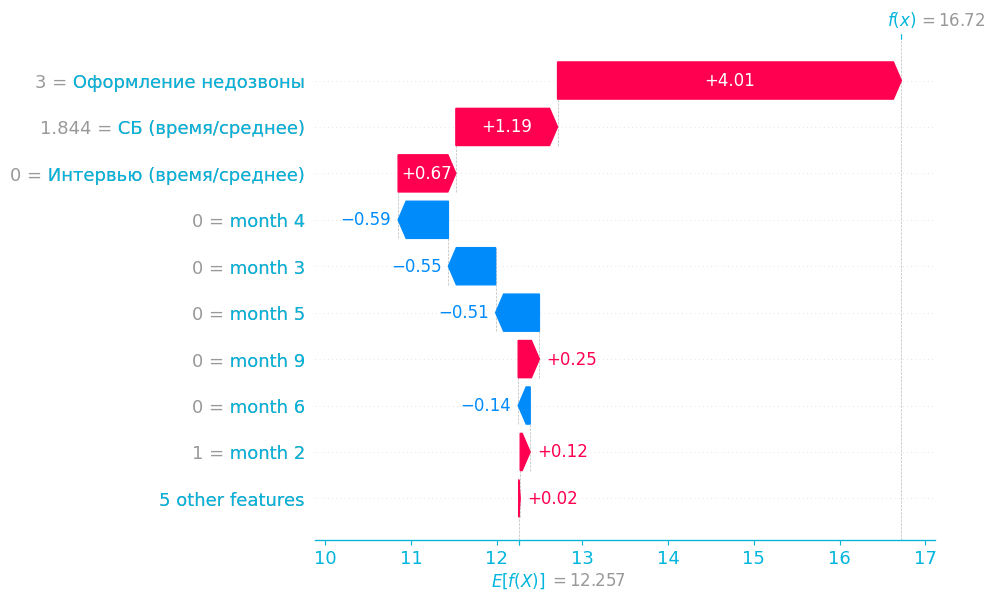

In [37]:
explainer = shap.Explainer(model_xgb)
shap_values = explainer(df_new)

# visualize the first prediction's explanation

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 15, 'text.color': colors[0],
                     'axes.labelcolor': colors[0], 'xtick.color': colors[0], 'ytick.color': colors[0],
                     'axes.edgecolor': colors[0], 'ytick.color': colors[0]})
shap.plots.waterfall(shap_values[0])

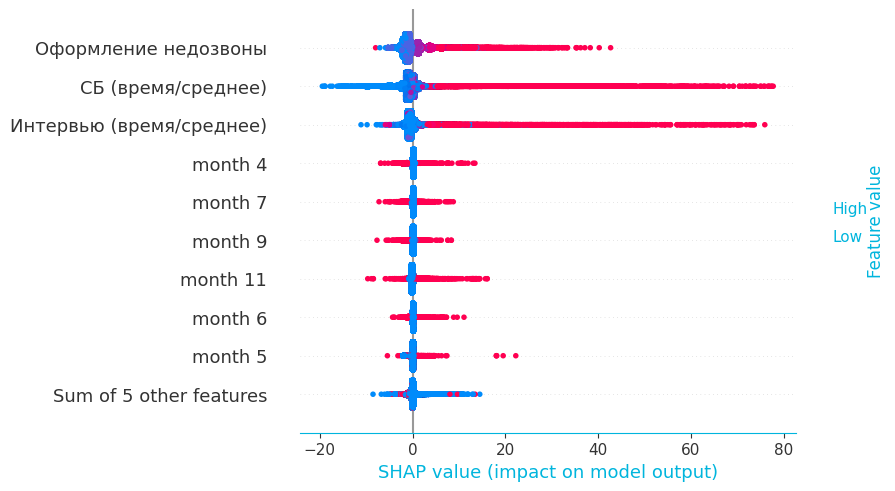

In [38]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 15, 'text.color': colors[0],
                     'axes.labelcolor': colors[0], 'xtick.color': colors[0], 'ytick.color': colors[0],
                     'axes.edgecolor': colors[0], 'ytick.color': colors[0]})

shap.plots.beeswarm(shap_values)

In [39]:
yColumn = "TTH"
fitted_model, xColumn, predicted = lm(df_reg,yColumn,['id_partner', 'department_id', 'id_applicant', 'TTH', 'year 2', 'month 12', 'yandex_source'], preprocessing.StandardScaler())
fitted_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
=========================================================================
Model:                OLS               Adj. R-squared:      0.267       
Dependent Variable:   TTH               AIC:                 1200387.8064
Date:                 2022-06-08 16:33  BIC:                 1200537.9455
No. Observations:     164271            Log-Likelihood:      -6.0018e+05 
Df Model:             14                F-statistic:         4279.       
Df Residuals:         164256            Prob (F-statistic):  0.00        
R-squared:            0.267             Scale:               87.304      
-------------------------------------------------------------------------
                          Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------
const                     8.9142   0.1394  63.9467 0.0000  8.6410  9.1875
month 1                  -0.9633   0.1730  -5.5670 0.0000 -1.3025 -0.6242
month 2                  -1.1439   0.1621  -7.0548 0.0000 -1.4617 -0.8261
month 3                  -1.8511   0.1587 -11.6637 0.0000 -2.1622 -1.5401
month 4                  -2.7496   0.1540 -17.8542 0.0000 -3.0515 -2.4478
month 5                  -1.7385   0.1575 -11.0399 0.0000 -2.0471 -1.4298
month 6                  -1.8939   0.1566 -12.0945 0.0000 -2.2009 -1.5870
month 7                  -2.3090   0.1549 -14.9060 0.0000 -2.6127 -2.0054
month 8                  -1.8389   0.1556 -11.8161 0.0000 -2.1440 -1.5339
month 9                  -2.2211   0.1559 -14.2506 0.0000 -2.5266 -1.9156
month 10                 -1.3460   0.1566  -8.5926 0.0000 -1.6530 -1.0390
month 11                 -0.5376   0.1669  -3.2216 0.0013 -0.8646 -0.2105
Оформление недозвоны      2.1441   0.0170 126.2189 0.0000  2.1108  2.1774
СБ (время/среднее)        1.9966   0.0110 181.9439 0.0000  1.9751  2.0181
Интервью (время/среднее)  0.5548   0.0042 133.5973 0.0000  0.5466  0.5629
-------------------------------------------------------------------------
Omnibus:             104488.202       Durbin-Watson:          1.926      
Prob(Omnibus):       0.000            Jarque-Bera (JB):       1420812.980
Skew:                2.897            Prob(JB):               0.000      
Kurtosis:            16.192           Condition No.:          119        
=========================================================================

"""

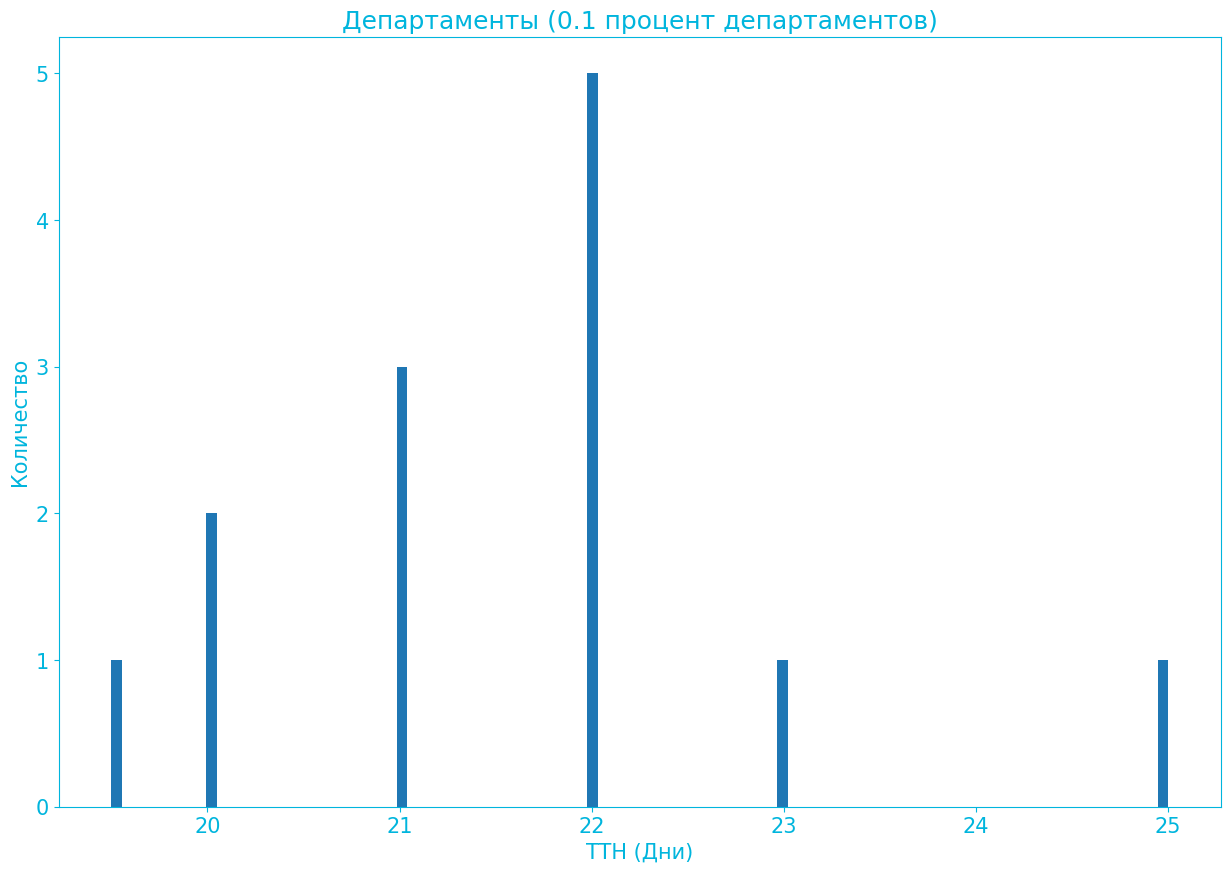

In [40]:
# График ТТН по департаментам (0,1 процент департаментов)
quantile_dep = df_tth_dep['TTH_median'].quantile(.999)
fig, ax = plt.subplots(1, 1,figsize=(15,10))
bins = 100
ax.hist(df_tth_dep['TTH_median'][(df_tth_dep['TTH_median']>quantile_dep)],bins=bins)
SetTTHLabels('Департаменты (0.1 процент департаментов)')
plt.show()


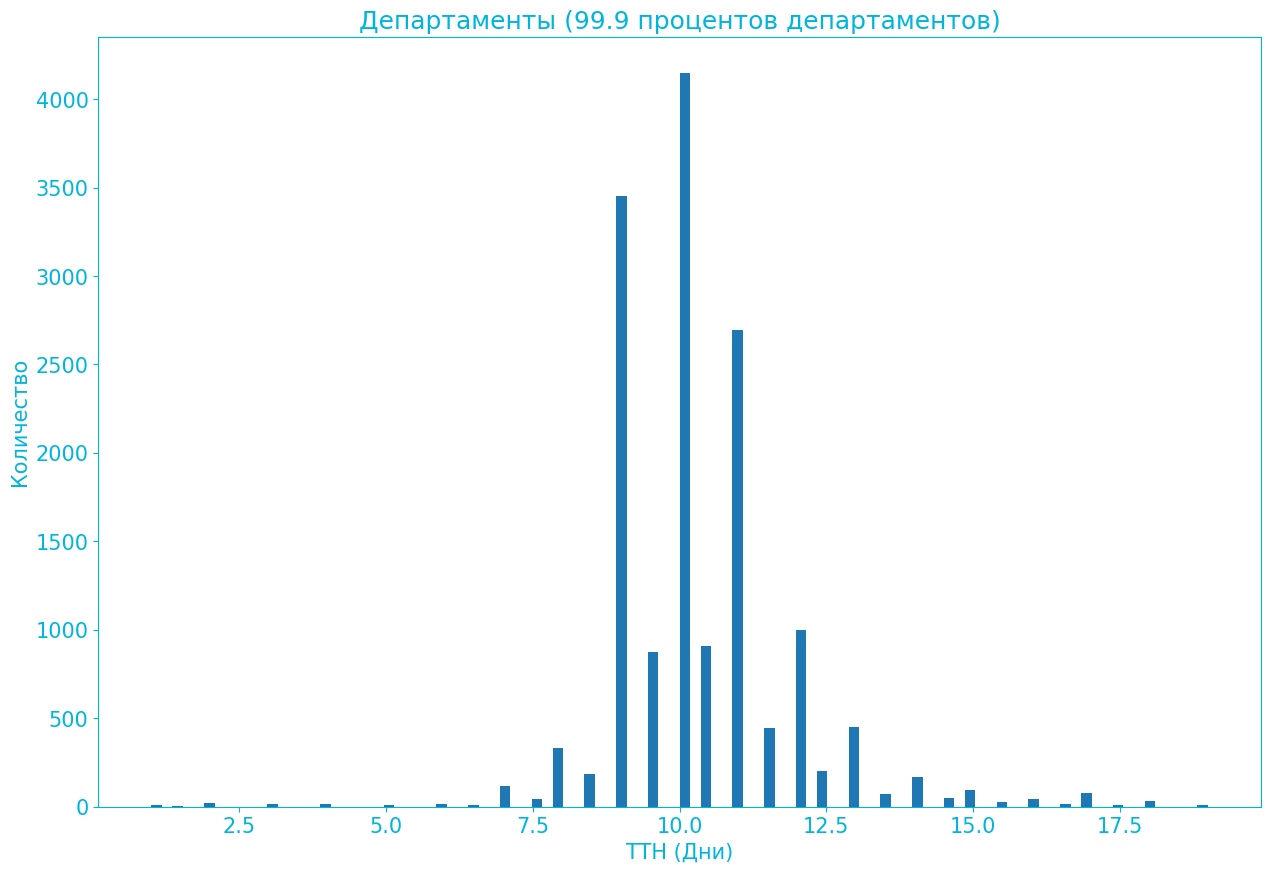

In [41]:
# График ТТН по департаментам (99,9 процентов департаментов)
fig, ax = plt.subplots(1, 1,figsize=(15,10))
bins = 100
ax.hist(df_tth_dep['TTH_median'][(df_tth_dep['TTH_median']<=quantile_dep)],bins=bins)
SetTTHLabels('Департаменты (99.9 процентов департаментов)')
plt.show()

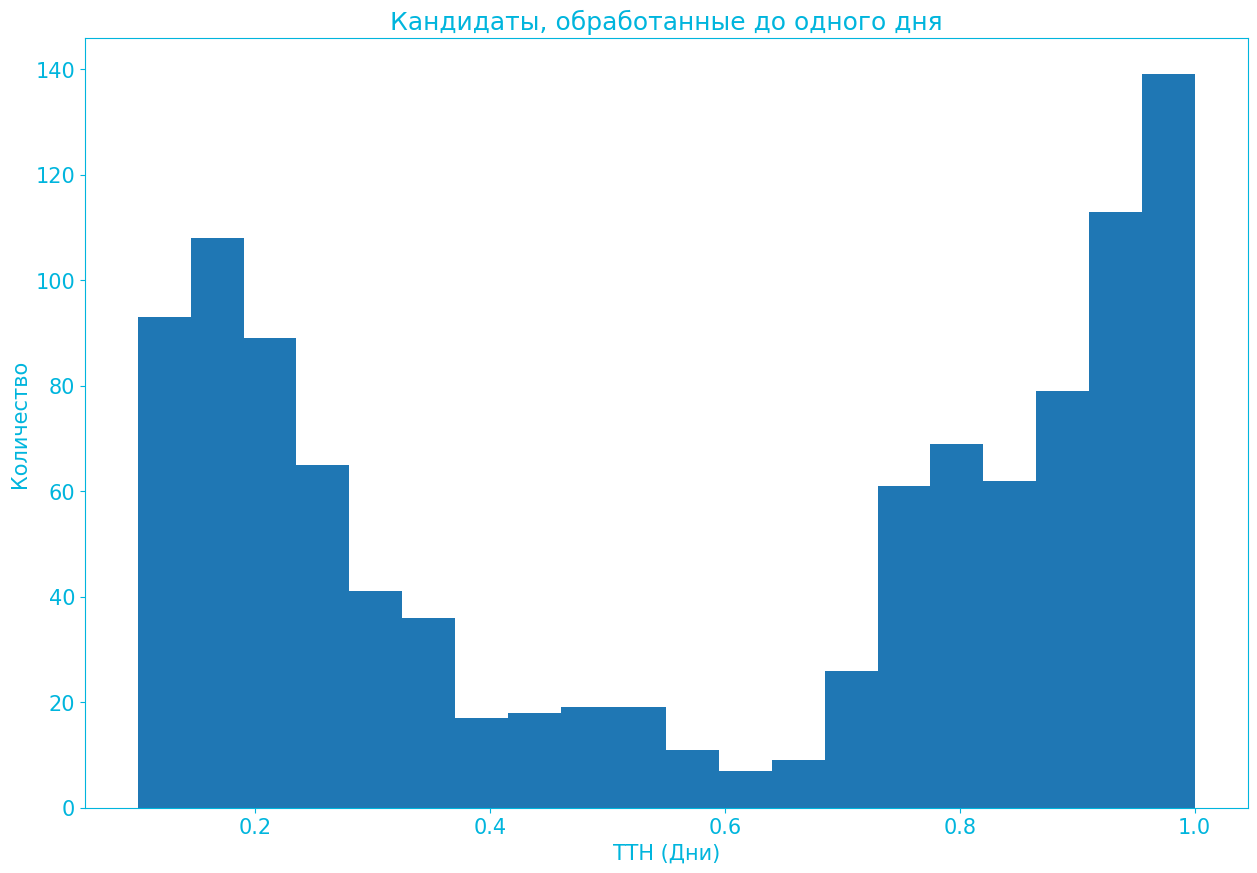

In [42]:
# График кандидатов, обработанных до одного дня
fig, ax = plt.subplots(1, 1,figsize=(15,10))
bins = 20
ax.hist(df_tth['TTH'][(df_tth['TTH']<=1)],bins=bins)
SetTTHLabels('Кандидаты, обработанные до одного дня')
plt.show()

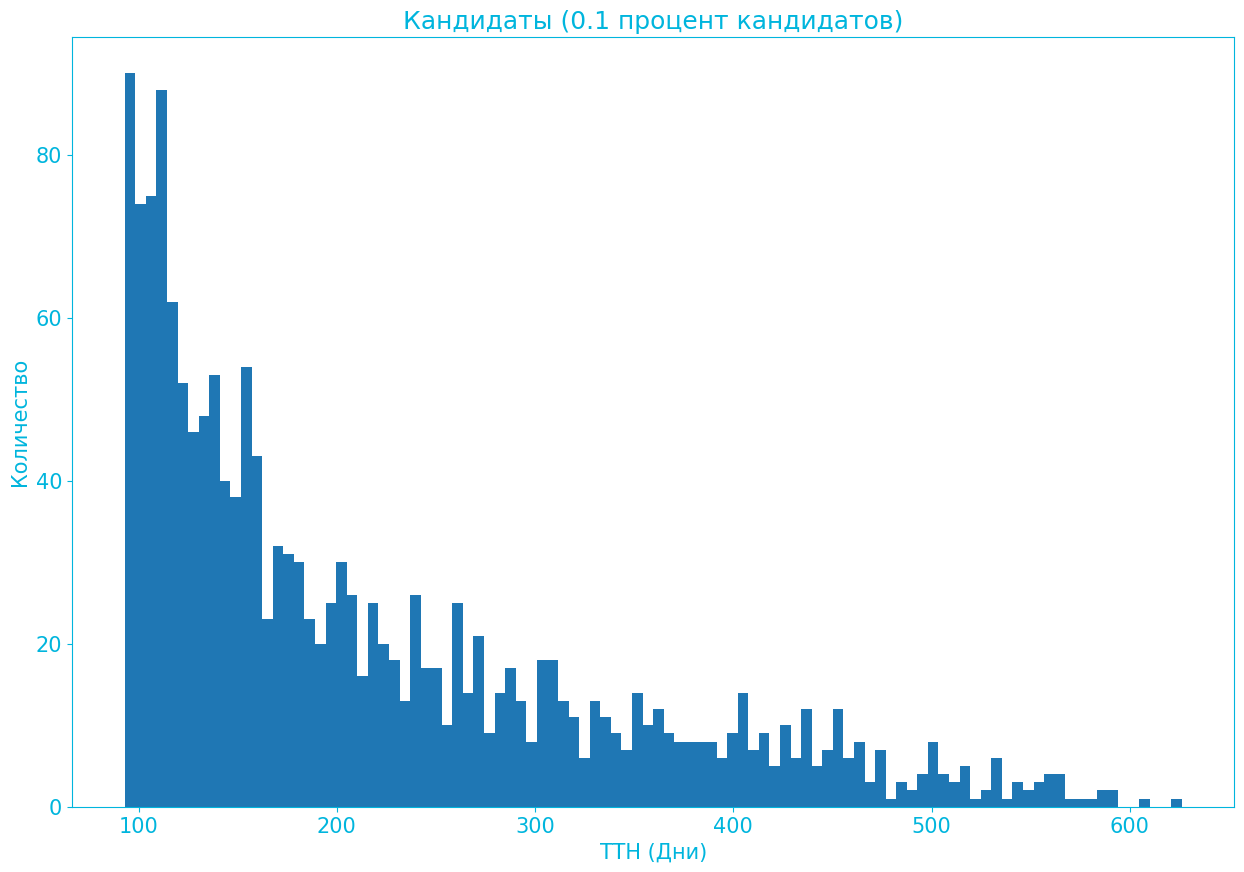

In [43]:
# График Кандидаты (0,1 процент кандидатов)
quantile_tth = df_tth['TTH'].quantile(.99)
fig, ax = plt.subplots(1, 1,figsize=(15,10))
ax.hist(df_tth['TTH'][(df_tth['TTH']<5000)&(df_tth['TTH']>quantile_tth)],bins=100)
SetTTHLabels('Кандидаты (0.1 процент кандидатов)')
plt.show()

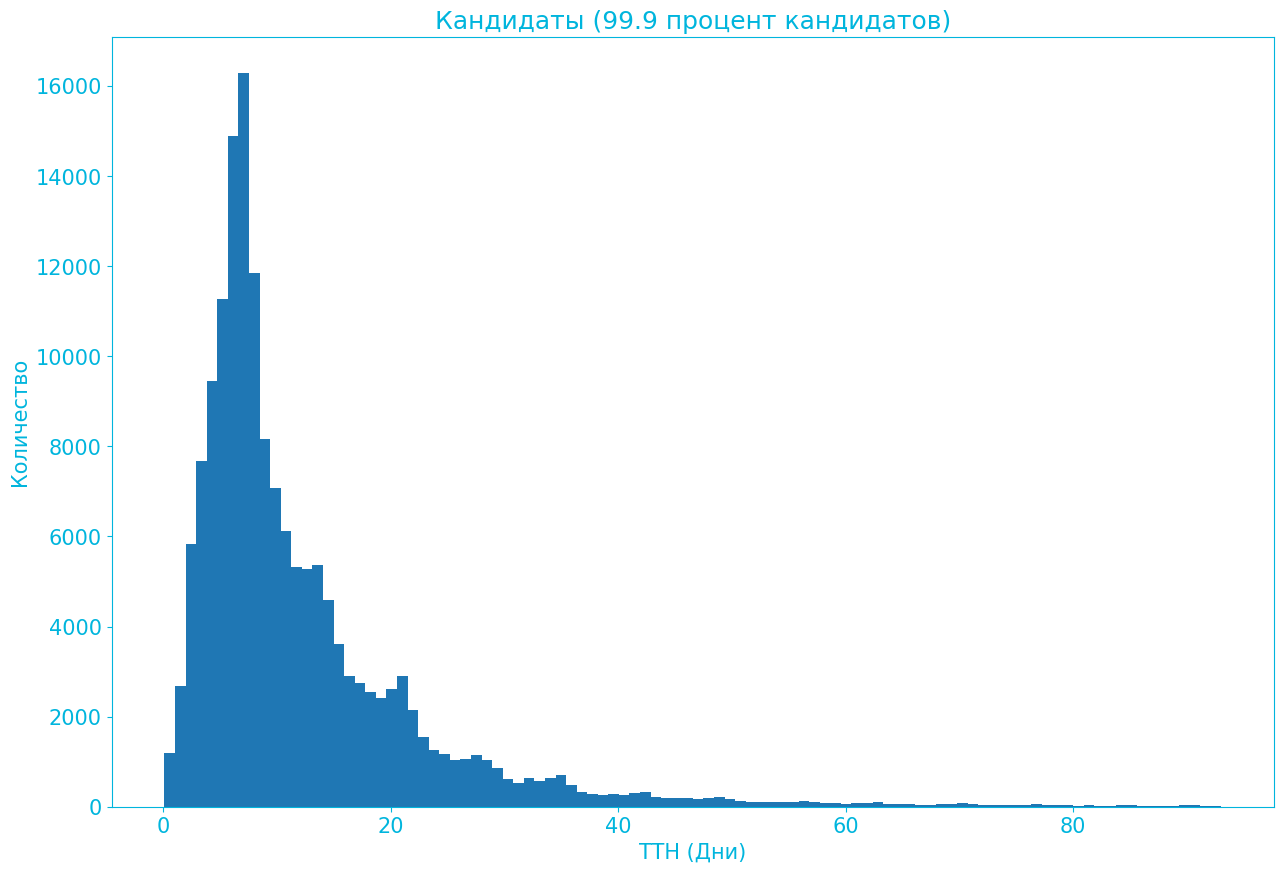

In [44]:
# График Кандидаты (99,9 процентов кандидатов)
fig, ax = plt.subplots(1, 1,figsize=(15,10))
ax.hist(df_tth['TTH'][(df_tth['TTH']<quantile_tth)& (df_tth['TTH']>0)], bins = 100)
SetTTHLabels('Кандидаты (99.9 процент кандидатов)')
plt.show()

In [45]:
# Построение когорты
df_min_date =df_fits.groupby(['id_applicant'])['action_date'].min().reset_index()
df_cohort = pd.merge(df_tth, df_min_date, how = 'left', on="id_applicant")
df_cohort.rename(columns = {'action_date':'creation_date'}, inplace = True)
fits_min =  df_fits[df_fits['result_name'] == 'Принят'].groupby(['id_applicant'])['action_date'].max().reset_index()
df_cohort = pd.merge(df_cohort, fits_min, how = 'left', on="id_applicant")
df_cohort.rename(columns = {'action_date':'applied_date'}, inplace = True)
date2018 = df_cohort['applied_date'].min().tzinfo.localize(pd.to_datetime(20180101, format='%Y%m%d'))
df_cohort['applied_date_days'] = (df_cohort['applied_date'] - date2018).dt.days % 365
df_cohort['creation_date_days'] = (df_cohort['creation_date'] - date2018).dt.days % 365

date2018 = df_cohort['applied_date'].min().tzinfo.localize(pd.to_datetime(20180101, format='%Y%m%d'))
df_cohort['weeks'] = (df_cohort['applied_date'] - date2018).dt.days
df_cohort['weeks'] = (df_cohort['weeks'] % 365 / 7).astype(int)
df_cohort['TTH_int'] = (df_cohort['TTH']/7).astype(int)
df_cohort

,id_applicant,id_partner,department_id,TTH,creation_date,applied_date,applied_date_days,creation_date_days,weeks,TTH_int
0,2196746,2393754,6715,27.685659,2018-01-05 06:37:15.434165+00:00,2018-02-01 23:04:53.450437+00:00,31,4,4,3
1,2196747,2314693,12252,6.133310,2018-01-05 06:37:54.019063+00:00,2018-01-11 09:51:21.213384+00:00,10,4,1,0
2,2196748,2346300,5760,28.251127,2018-01-05 06:39:55.362530+00:00,2018-02-02 12:41:49.992103+00:00,32,4,4,4
3,2196752,2393757,32391,17.202996,2018-01-05 06:50:30.704473+00:00,2018-01-22 11:43:14.342473+00:00,21,4,3,2
4,2196753,2393758,32156,10.153854,2018-01-05 06:50:31.727665+00:00,2018-01-15 10:32:20.674998+00:00,14,4,2,1
...,...,...,...,...,...,...,...,...,...,...
165915,4874547,3857100,35046,2.984132,2020-04-10 17:10:11.297074+00:00,2020-04-13 16:47:34.290655+00:00,103,100,14,0
165916,4874561,3843493,24135,2.981270,2020-04-10 17:12:31.084382+00:00,2020-04-13 16:45:57.073435+00:00,103,100,14,0
165917,4874899,3847746,45624,2.944752,2020-04-10 18:37:18.462768+00:00,2020-04-13 17:18:34.828264+00:00,103,100,14,0
165918,4875075,3873082,9996,2.186676,2020-04-11 08:31:29.677060+00:00,2020-04-13 13:00:37.290286+00:00,103,101,14,0


In [46]:
# Функции для построения графиков
def showHist(data, grouped_data, column_name = 'stage_name', col_threshold = 0, is_special = True, xy = 4):
    
    fig, axs = plt.subplots(xy, xy, figsize=(20,15))
    i = 0
    not_special_const = 5
    
    for col in data[column_name].unique():
        series = data['action_time'][data[column_name] == col]
        time_threshold = not_special_const
        if is_special and col in grouped_data.index:
            time_threshold = grouped_data.loc[col]['75%']
        col_len = len(series)
    
        if col_len > col_threshold:
            x, y =divmod(i, xy)
            i+=1
            axs[x,y].set_xlabel(f'{col}, {col_len}')
            series[series.values < time_threshold].hist(ax=axs[x,y],bins=100)
        print('.', end = '')
    plt.show()

def checkShowHist(data, grouped_data, column_name = 'stage_name', col_threshold = 0, is_special = True, xy = 4):
    
    not_special_const = 5
    if is_special and len(data[column_name].unique()) != len(grouped_data):
        print('Not all columns in grouped_data')
    
    i = 0
    for col in data[column_name].unique():
        series = data['action_time'][data[column_name] == col]
        col_len = len(series)
    
        if col_len > col_threshold:
            x, y =divmod(i, xy)
            if x > xy or y > xy:
                print(f'Too many columns in data for diagramm {xy}*{xy}')                
            i+=1